## Classification results

This notebook contains functions to measure the performance of a classifier applied over a set of annotations.

The output of the classification files is expected to be compatible with the output of the UKPLab models. Each line contains the token, the true label, and predicted label of one classification example, in that order, separated by tabs. The first row has the columns names. For example:

`word_n    I-Premise:2:Support    I-Premise:-1:Support`

Training results must be stored in tsv format with the following columns: epoch, modelName, dev_score, test_score, max_dev_score, max_test_score

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import pickle
import os
import re
import seaborn as sns
from sklearn import metrics
sns.set_style('white')
sns.set_palette('colorblind')

/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [41]:
CC_EXPERIMENTS_DIRS = [
    ## First exploration  # Timewise without activation
    '../../results/ukpnets/paragraph/18-08-18-16-54/',  # Best in exploration
    '../../results/ukpnets/paragraph/18-08-18-19-06/',
    '../../results/ukpnets/paragraph/18-08-18-21-48/',
    '../../results/ukpnets/paragraph/18-08-18-23-05/',
    '../../results/ukpnets/paragraph/18-08-19-01-06/',
    ##
    '../../results/ukpnets/paragraph/18-08-23-14-47/',  # Timewise with tanh activation
    ## Second exploration / No attention
    '../../results/ukpnets/paragraph/18-08-24-01-22/',
    '../../results/ukpnets/paragraph/18-08-24-02-49/',
    '../../results/ukpnets/paragraph/18-08-24-04-13/',
    '../../results/ukpnets/paragraph/18-08-24-05-14/',  # Best in exploration
    ##
    '../../results/ukpnets/paragraph/18-08-29-18-24/',  # Full eval of 18-08-18-16-54
    ## Feature wise exploration
    '../../results/ukpnets/paragraph/18-08-31-00-22/',
    '../../results/ukpnets/paragraph/18-08-31-03-15/',
    '../../results/ukpnets/paragraph/18-08-31-05-57/',
    '../../results/ukpnets/paragraph/18-08-31-08-04/',
    '../../results/ukpnets/paragraph/18-08-31-10-52/',
    ###
    '../../results/ukpnets/paragraph/18-08-31-16-52/',  # Full eval featurewise
    ## Timewise exploration tanh
    '../../results/ukpnets/paragraph/18-08-31-16-54/',
    '../../results/ukpnets/paragraph/18-08-31-18-27/',
    '../../results/ukpnets/paragraph/18-08-31-20-21/',
    '../../results/ukpnets/paragraph/18-08-31-22-09/',
    '../../results/ukpnets/paragraph/18-08-31-23-54/',
    ##
    '../../results/ukpnets/paragraph/18-09-01-14-32/',
    '../../results/ukpnets/paragraph/18-09-01-17-14/',
    '../../results/ukpnets/paragraph/18-09-01-19-04/',
    '../../results/ukpnets/paragraph/18-09-01-',
]

## Classification Results - Dev and Test

In [35]:
def labels_single_file(filename):
    result = pandas.read_csv(filename, sep='\t')
    return result

In [36]:
def prediction_filenames(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'predictions' in run_prediction]

In [37]:
def metrics_single_classifier(classifier_dirpath):
    """Reads all partitions for a single classifier."""
    result = pandas.DataFrame(columns=[
        'Classifier', 'Partition', 'Dataset',
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support'])
    for index, prediction_file in enumerate(prediction_filenames(classifier_dirpath)):
        predictions = labels_single_file(os.path.join(classifier_dirpath, prediction_file))
        accuracy = metrics.accuracy_score(predictions['True'], predictions.Predicted)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(
            predictions['True'], predictions.Predicted, average='weighted', warn_for=[])
        support = len(predictions)
        partition = re.search('.*partition(\d+).*', prediction_file).group(1)
        dataset = re.search('.*ukp_(\w+).conll', prediction_file).group(1)
        classifier = os.path.basename(os.path.normpath(classifier_dirpath))
        result.loc[index] = [classifier, partition, dataset, accuracy, precision, recall, f1, support]
    return result

In [38]:
def experiments_metrics(experiments_dirs):
    """Reads metrics for all classifiers"""
    classifier_metrics = []
    for classifier_path in experiments_dirs:
        classifier_metrics.append(metrics_single_classifier(classifier_path))
    return pandas.concat(classifier_metrics)

## COMPONENT CLASSIFICATION

### Classifier summary

In [43]:
cc_results = experiments_metrics(CC_EXPERIMENTS_DIRS)

In [46]:
grouped_res = cc_results[cc_results.Dataset == 'dev'].groupby('Classifier').agg(['mean', 'std'])
grouped_res

Accuracy           Precision              Recall            \
                    mean       std      mean       std      mean       std   
Classifier                                                                   
18-08-18-16-54  0.655625  0.086759  0.685463  0.072217  0.655625  0.086759   
18-08-18-19-06  0.649506  0.103861  0.671613  0.093725  0.649506  0.103861   
18-08-18-21-48  0.635555  0.055047  0.684210  0.066876  0.635555  0.055047   
18-08-18-23-05  0.637611  0.085253  0.692411  0.098359  0.637611  0.085253   
18-08-19-01-06  0.602329  0.057197  0.645115  0.046316  0.602329  0.057197   
18-08-23-14-47  0.628291  0.033425  0.661790  0.064760  0.628291  0.033425   
18-08-24-01-22  0.578260  0.084970  0.609708  0.086937  0.578260  0.084970   
18-08-24-02-49  0.566750  0.065132  0.599985  0.045250  0.566750  0.065132   
18-08-24-04-13  0.588828  0.058606  0.611308  0.048711  0.588828  0.058606   
18-08-24-05-14  0.605893  0.051872  0.632341  0.070130  0.605893  0.051872   
18-08-29-18-24  0.659971  0.053349  0.680887  0.055519  0.659971  0.053349   
18-08-31-00-22  0.599089  0.125632  0.601394  0.089324  0.599089  0.125632   
18-08-31-03-15  0.576990  0.138484  0.485250  0.189802  0.576990  0.138484   
18-08-31-05-57  0.561845  0.101854  0.594705  0.112523  0.561845  0.101854   
18-08-31-08-04  0.584058  0.079373  0.568449  0.075419  0.584058  0.079373   
18-08-31-10-52  0.560375  0.102551  0.566780  0.077594  0.560375  0.102551   
18-08-31-16-52  0.608808  0.053236  0.598652  0.044808  0.608808  0.053236   
18-08-31-16-54  0.588415  0.067155  0.644135  0.073139  0.588415  0.067155   
18-08-31-18-27  0.586502  0.066958  0.616413  0.054856  0.586502  0.066958   
18-08-31-20-21  0.638807  0.046542  0.646835  0.048802  0.638807  0.046542   
18-08-31-22-09  0.626992  0.027824  0.638939  0.042905  0.626992  0.027824   
18-08-31-23-54  0.627942  0.064237  0.659551  0.063707  0.627942  0.064237   
18-09-01-14-32  0.637590  0.071850  0.672811  0.077862  0.637590  0.071850   
18-09-01-17-14  0.600498  0.068008  0.602655  0.053118  0.600498  0.068008   
18-09-01-19-04  0.624947  0.071694  0.664753  0.070847  0.624947  0.071694   

                F1-Score            
                    mean       std  
Classifier                          
18-08-18-16-54  0.657438  0.087300  
18-08-18-19-06  0.647137  0.108553  
18-08-18-21-48  0.633596  0.059280  
18-08-18-23-05  0.648202  0.085050  
18-08-19-01-06  0.610298  0.056608  
18-08-23-14-47  0.626305  0.044376  
18-08-24-01-22  0.566716  0.087436  
18-08-24-02-49  0.569196  0.056559  
18-08-24-04-13  0.592746  0.055990  
18-08-24-05-14  0.607082  0.053401  
18-08-29-18-24  0.662929  0.052282  
18-08-31-00-22  0.582985  0.127392  
18-08-31-03-15  0.520138  0.171706  
18-08-31-05-57  0.556214  0.102616  
18-08-31-08-04  0.560512  0.065144  
18-08-31-10-52  0.540315  0.102147  
18-08-31-16-52  0.593739  0.048359  
18-08-31-16-54  0.597460  0.064775  
18-08-31-18-27  0.591361  0.067214  
18-08-31-20-21  0.637931  0.043603  
18-08-31-22-09  0.622205  0.037468  
18-08-31-23-54  0.630146  0.069679  
18-09-01-14-32  0.639778  0.075922  
18-09-01-17-14  0.593905  0.063664  
18-09-01-19-04  0.626624  0.067986

/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


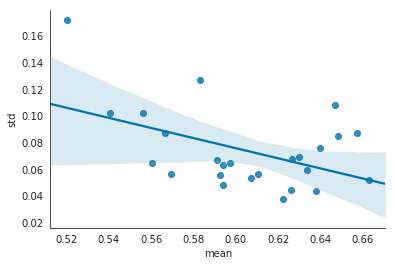

In [51]:
sns.regplot(data=grouped_res['F1-Score'], x='mean', y='std')
sns.despine()

In [55]:
import scipy

scipy.stats.pearsonr(
    numpy.concatenate([grouped_res['F1-Score']['mean'].values,
                       [0.6295745 , 0.66930559, 0.55565738, 0.63846874, 0.62891957,
       0.64974718, 0.59998085, 0.6145782 , 0.62464497, 0.63076423,
       0.6811388 , 0.5939722 , 0.60044117, 0.5755026 , 0.61893256,
       0.59239286, 0.61974816, 0.55439312, 0.50391005, 0.48650978,
       0.55156754]]),
    numpy.concatenate([grouped_res['F1-Score']['std'].values,
                       [0.06118095, 0.07122037, 0.08904738, 0.07970727, 0.05178662,
       0.06408423, 0.03669589, 0.04220545, 0.06222918, 0.06457822,
       0.05890809, 0.05257426, 0.03318479, 0.06533591, 0.04764824,
       0.02017141, 0.0332668 , 0.09964752, 0.15304509, 0.15810122,
       0.07706009]]))

(-0.5773635422898868, 2.659716969662071e-05)

### Comparison between classifiers

/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


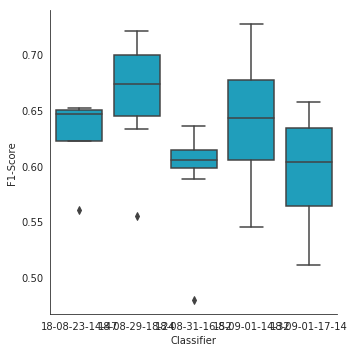

In [33]:
sns.factorplot(data=cc_results[cc_results.Dataset == 'dev'],
               x='Classifier', kind='box', y='F1-Score', color='#06aed5')

In [23]:
METRIC_COLS = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

cc_results_stacked_metrics = cc_results.set_index(['Classifier', 'Dataset', 'Partition']).drop(
    columns='Support').stack().reset_index().rename(columns={0: 'Metric Value', 'level_3': 'Metric'})

/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


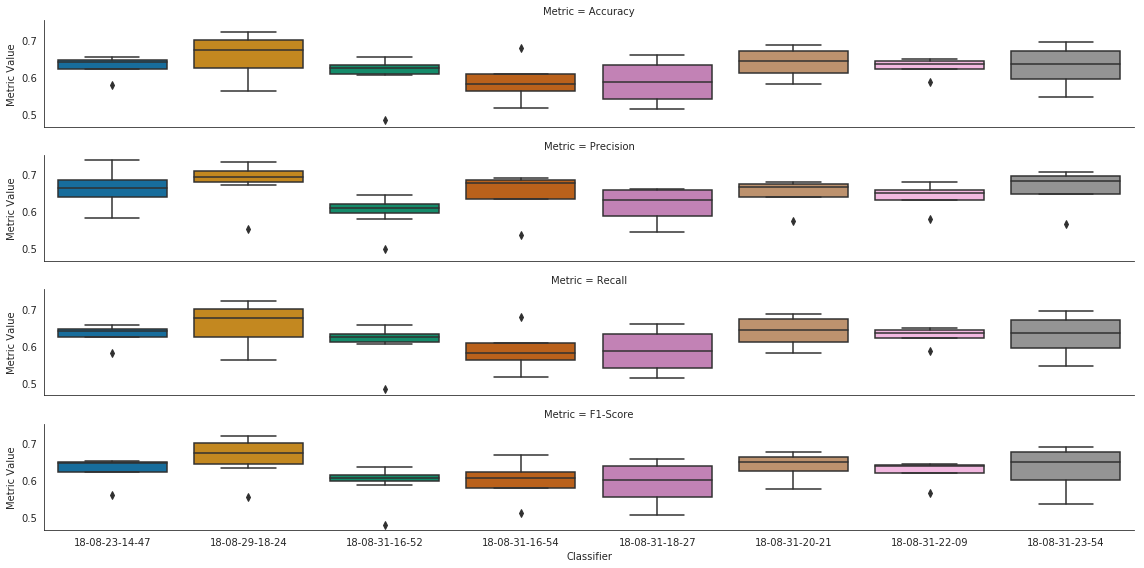

In [24]:
sns.factorplot(data=cc_results_stacked_metrics[cc_results_stacked_metrics.Dataset == 'dev'],
               x='Classifier', kind='box', y='Metric Value', row='Metric', aspect=8, size=2)

/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


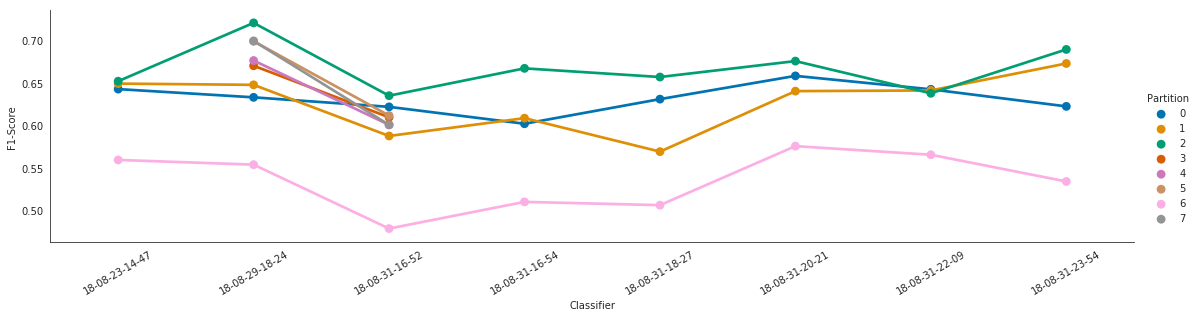

In [25]:
g = sns.factorplot(data=cc_results[cc_results.Dataset == 'dev'],
               x='Classifier', y='F1-Score', hue='Partition', aspect=4, size=4)
g.set_xticklabels(rotation=30)

### Metrics with respect to support

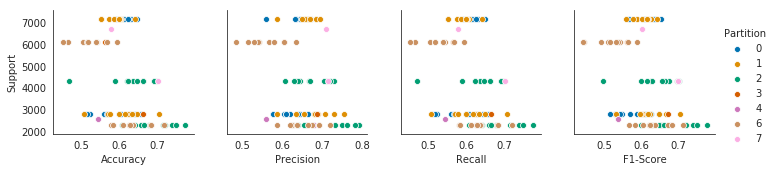

In [53]:
sns.pairplot(data=cc_results, x_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
             y_vars=['Support'], hue='Partition')

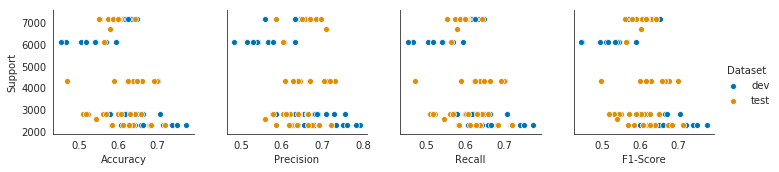

In [54]:
sns.pairplot(data=cc_results, x_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
             y_vars=['Support'], hue='Dataset')

## Learning rate

In [14]:
def learning_single_file(filename):
    result = pandas.read_csv(
        filename, sep='\t', header=None,
        names=['epoch', 'model_name', 'dev_score', 'test_score', 'max_dev_score', 'max_test_score'])
    return result

In [15]:
def learning_filenames(dirname):
    return [learning_metrics for learning_metrics in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, learning_metrics)) and 'results' in learning_metrics]

In [16]:
def learning_metrics_single_classifier(classifier_dirpath):
    """Reads all partitions for a single classifier."""
    result = []
    for index, results_file in enumerate(learning_filenames(classifier_dirpath)):
        learning_metrics = learning_single_file(os.path.join(classifier_dirpath, results_file)).drop(
            columns=['model_name', 'max_dev_score', 'max_test_score'])
        learning_metrics = learning_metrics.set_index(['epoch']).stack().reset_index().rename(
            columns={0: 'Metric Value', 'level_1': 'Dataset'})
        learning_metrics['Partition'] = re.search('.*partition(\d+).*', results_file).group(1)
        learning_metrics['Classifier'] = os.path.basename(os.path.normpath(classifier_dirpath))
        result.append(learning_metrics)
    return pandas.concat(result)

In [17]:
def learning_metrics(experiment_dirs):
    """Reads learning metrics for all classifiers"""
    classifier_learning_metrics = []
    for classifier_path in experiment_dirs:
        classifier_learning_metrics.append(learning_metrics_single_classifier(classifier_path))
    return pandas.concat(classifier_learning_metrics)

In [18]:
cc_learning = learning_metrics(CC_EXPERIMENTS_DIRS)
cc_learning[:3]

,epoch,Dataset,Metric Value,Partition,Classifier
0,1,dev_score,0.407420,0,18-08-23-14-47
1,1,test_score,0.385899,0,18-08-23-14-47
2,2,dev_score,0.504340,0,18-08-23-14-47


/users/mteruel/anaconda3/envs/edm_env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


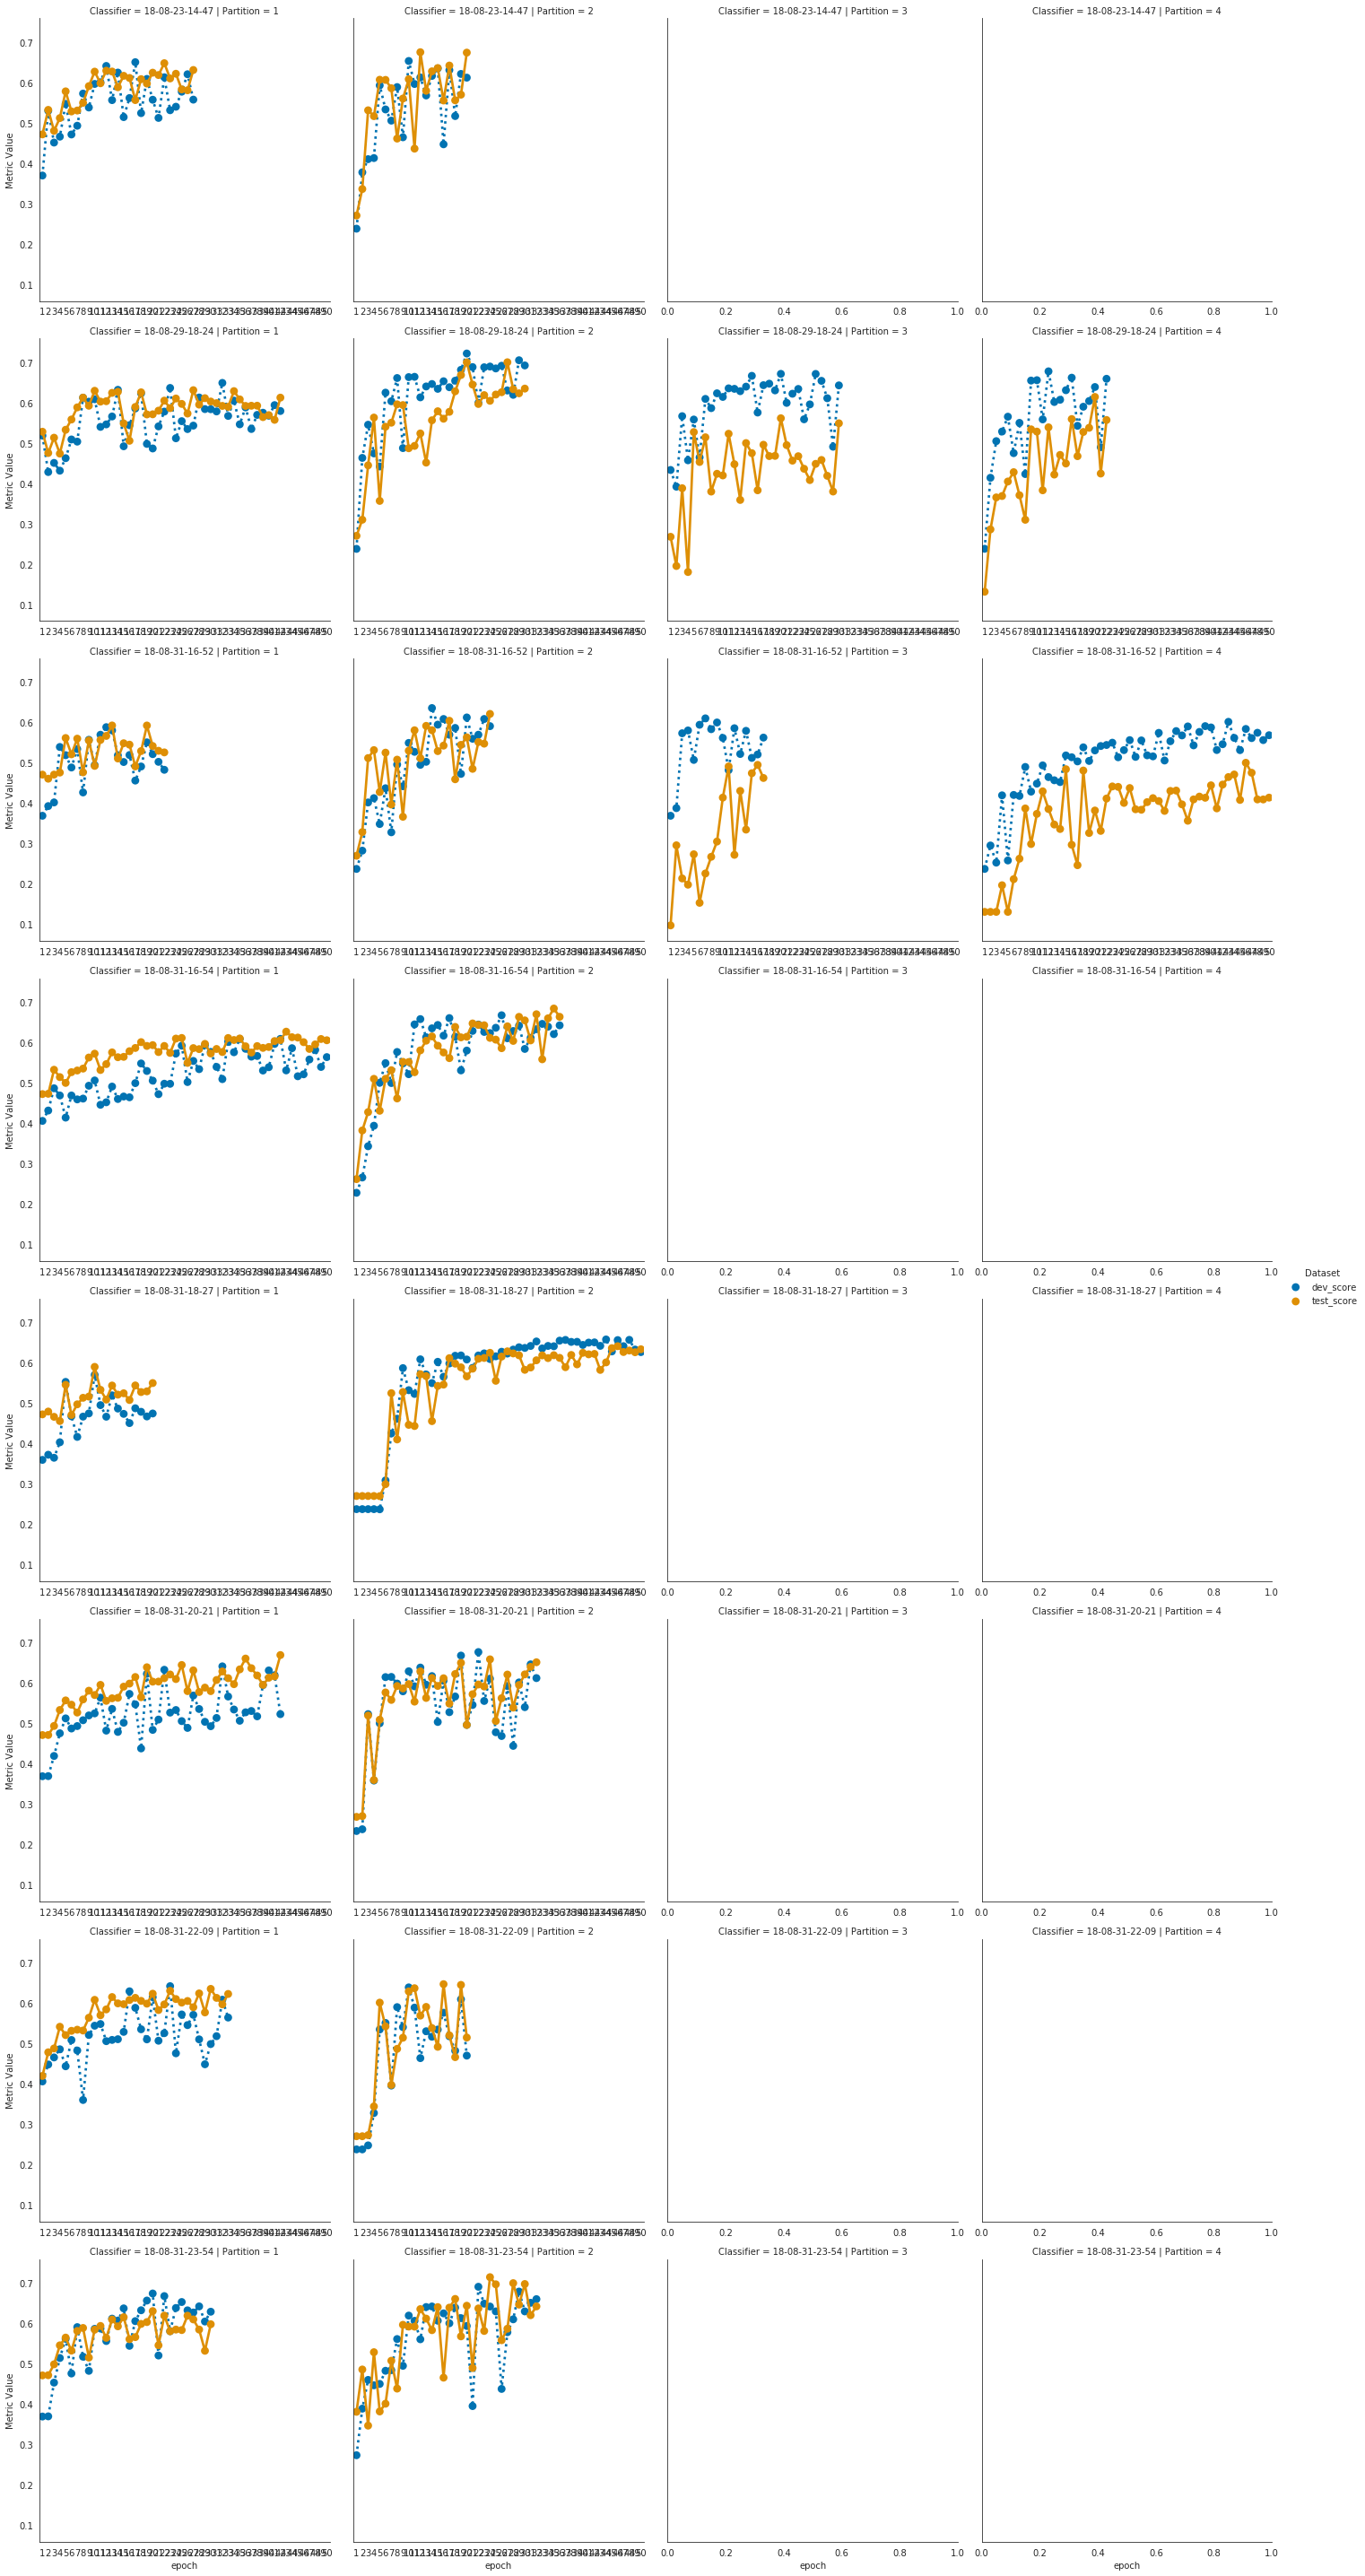

In [19]:
sns.factorplot(data=cc_learning[cc_learning.Partition.isin(['1', '2', '3', '4'])],
               row='Classifier', x='epoch', y='Metric Value', hue='Dataset',
               linestyles=[":", "-"], col='Partition', sharex=False, hue_order=['dev_score', 'test_score'])

### Confusion matrix

In [178]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Args:
        confusion_matrix: numpy.ndarray
            The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
            Similarly constructed ndarrays can also be used.
        class_names: list
            An ordered list of class names, in the order they index the given confusion matrix.
        figsize: tuple
            A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
            the second determining the vertical size. Defaults to (10,7).
        fontsize: int
            Font size for axes labels. Defaults to 14.
        
    Returns:
        The resulting confusion matrix figure
    """
    df_cm = pandas.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [179]:
def plot_confusion_matrix(classifier_name, partition=0):
    for classifier_dirname in CC_EXPERIMENTS_DIRS:
        if not classifier_name in classifier_dirname:
            continue
        prediction_files = prediction_filenames(classifier_dirname)
        prediction_file = None
        for possible_prediction_file in prediction_files:
            if 'partition' + str(partition) in possible_prediction_file and 'dev' in possible_prediction_file:
                prediction_file = possible_prediction_file
                break
        if prediction_file is None:
            raise ValueError('No prediction for the given partition')
        predictions = labels_single_file(os.path.join(classifier_dirname, prediction_file))
        labels = numpy.unique(numpy.concatenate([predictions['True'].values, predictions.Predicted.values]))
        print(metrics.classification_report(predictions['True'], predictions.Predicted, labels=labels))
        cm = metrics.confusion_matrix(predictions['True'], predictions.Predicted, labels=labels)
        print(cm.sum())
        print_confusion_matrix(cm, labels)
        return None
    raise ValueError('Classifier not found')

             precision    recall  f1-score   support

    B-claim       0.36      0.53      0.43        17
  B-premise       0.42      0.31      0.36        35
    I-claim       0.28      0.61      0.39       334
  I-premise       0.59      0.60      0.59       931
          O       0.89      0.65      0.75      1493

avg / total       0.71      0.62      0.65      2810

2810


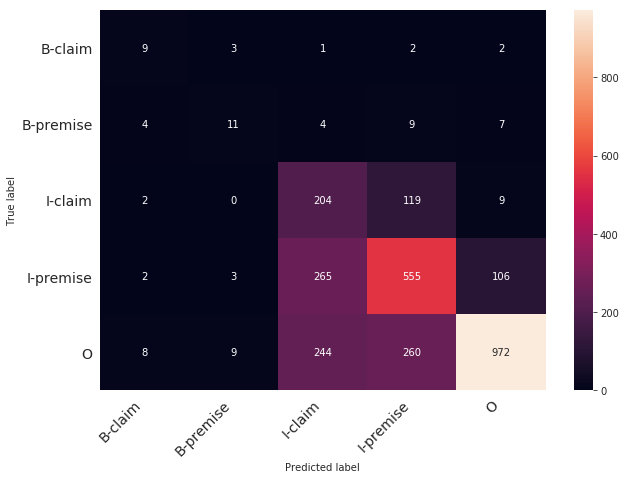

In [182]:
plot_confusion_matrix('18-08-29-18-24', partition=1)